# Factor Returns

## Install packages

In [ ]:
import sys

In [ ]:
!{sys.executable} -m pip install -r requirements.txt

In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import os
import quiz_helper
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### data bundle

In [3]:
import os
import quiz_helper
from zipline.data import bundles

In [4]:
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..','data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], quiz_helper.EOD_BUNDLE_NAME)
bundles.register(quiz_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build pipeline engine

In [6]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(quiz_helper.EOD_BUNDLE_NAME)
engine = quiz_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [7]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

# Get Returns data

In [8]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [9]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

## get pricing data into a dataframe

In [10]:
returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000
2011-01-21 00:00:00+00:00,0.007873,-0.041038,0.005544,-0.017911,0.000000,0.010642,-0.000853,-0.001952,-0.006569,-0.004113,...,0.000000,0.000615,0.015825,-0.003048,-0.000872,0.000000,-0.007590,0.009325,0.024020,0.000000


## Sector data helper function
We'll create an object for you, which defines a sector for each stock.  The sectors are represented by integers.  We inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [11]:
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype
class Sector(Classifier):
    dtype = int64_dtype
    window_length = 0
    inputs = ()
    missing_value = -1

    def __init__(self):
        self.data = np.load('../../data/project_4_sector/data.npy')

    def _compute(self, arrays, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value,
        )

In [12]:
sector = Sector()

## We'll use 2 years of data to calculate the factor

**Note:** Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open.

In [13]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

## Create smoothed momentum factor

In [14]:
from zipline.pipeline.factors import Returns
from zipline.pipeline.factors import SimpleMovingAverage


# create a pipeline called p
p = Pipeline(screen=universe)
# create a factor of one year returns, deman by sector, then rank
factor = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()). #we use the custom Sector class that we reviewed earlier
    rank().
    zscore()
)


# Use this factor as input into SimpleMovingAverage, with a window length of 5
# Also rank and zscore (don't need to de-mean by sector, s)
factor_smoothed = (
    SimpleMovingAverage(inputs=[factor], window_length=5).
    rank().
    zscore()
)

# add the unsmoothed factor to the pipeline
p.add(factor, 'Momentum_Factor')
# add the smoothed factor to the pipeline too
p.add(factor_smoothed, 'Smoothed_Momentum_Factor')

## visualize the pipeline

Note that if the image is difficult to read in the notebook, right-click and view the image in a separate tab.

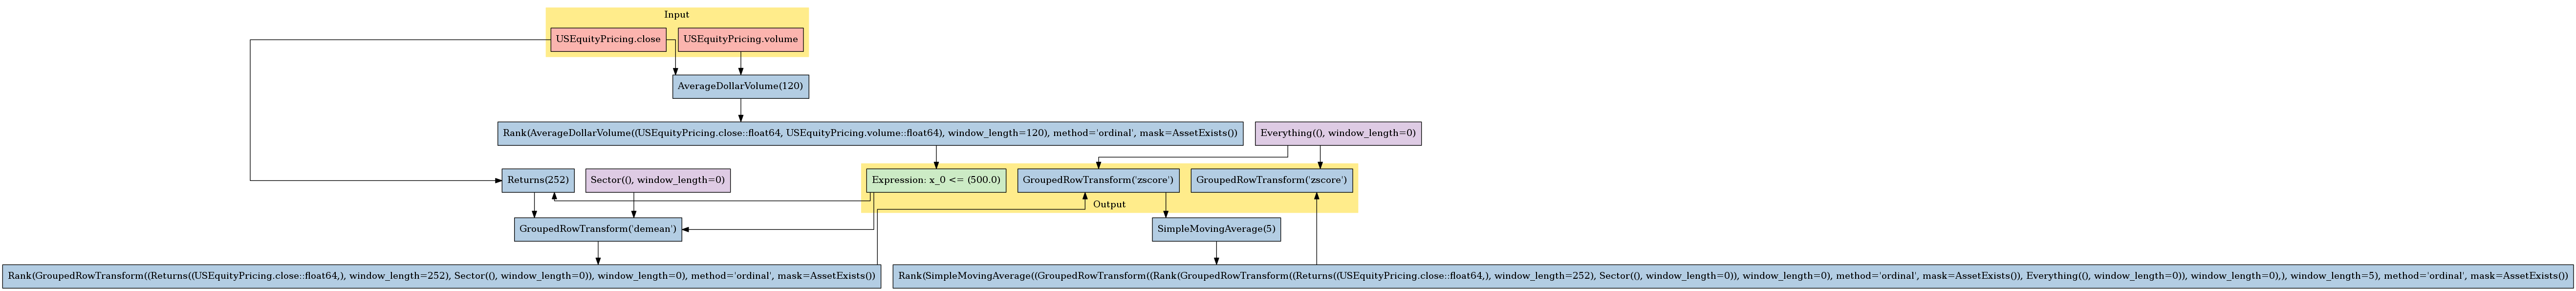

In [15]:
p.show_graph(format='png')

## run pipeline and view the factor data

In [16]:
df = engine.run_pipeline(p, factor_start_date, universe_end_date)

In [17]:
df.head()

Momentum_Factor  \
2014-01-03 00:00:00+00:00 Equity(0 [A])            1.499391   
                          Equity(1 [AAL])          1.602797   
                          Equity(2 [AAP])          0.376694   
                          Equity(3 [AAPL])        -1.484618   
                          Equity(4 [ABBV])         0.915884   

                                            Smoothed_Momentum_Factor  
2014-01-03 00:00:00+00:00 Equity(0 [A])                     1.484618  
                          Equity(1 [AAL])                   1.573252  
                          Equity(2 [AAP])                   0.206813  
                          Equity(3 [AAPL])                 -1.477232  
                          Equity(4 [ABBV])                  0.945429

## Evaluate Factors

We'll go over some tools that we can use to evaluate alpha factors.  To do so, we'll use the [alphalens library](https://github.com/quantopian/alphalens)


## Import alphalens

In [18]:
import alphalens as al

## Get price data

Note, we already got the price data and converted it to returns, which we used to calculate a factor.  We'll retrieve the price data again, but won't convert these to returns.  This is because we'll use alphalens functions that take their input as prices and not returns.

## Define the list of assets
Just to make sure we get the prices for the stocks that have factor values, we'll get the list of assets, which may be a subset of the original universe

In [19]:
# get list of stocks in our portfolio (tickers that identify each stock)
assets = df.index.levels[1].values.tolist()
print(f"stock universe number of stocks {len(universe_tickers)}, and number of stocks for which we have factor values {len(assets)}")

stock universe number of stocks 490, and number of stocks for which we have factor values 490


In [20]:
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

In [21]:
pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets, #notice that we used assets instead of universe_tickers; in this example, they're the same
        factor_start_date, # notice we're using the same start and end dates for when we calculated the factor
        universe_end_date)

## Prepare data for use in alphalens


In [22]:
factor_names = df.columns
print(f"The factor names are {factor_names}")
factor_data = {}
for factor_name in factor_names:
    print("Formatting factor data for: " + factor_name)
    # get clean factor and forward returns for each factor
    factor_data[factor_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=df[factor_name],
        prices=pricing,
        periods=[1])

The factor names are Index(['Momentum_Factor', 'Smoothed_Momentum_Factor'], dtype='object')
Formatting factor data for: Momentum_Factor
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Smoothed_Momentum_Factor
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## factor returns

What are factor-weighted returns? We may also refer to this as "factor returns".  

If you created a theoretical portfolio in which the weights for each stock were chosen based on the factor scores (the z-scores we calculated earlier), then we could calculate the daily returns of that theoretical portfolio.  

The returns of this portfolio, in which its weights were determined by the alpha factor, are called the "factor-weighted returns", and also referred to as "factor returns."

### Alphalens factor_returns

Alphalens has a function that calculates the factor returns, called alphalens.performance.factor_returns.  The [documentation is here](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_returns#alphalens.performance.factor_returns).  

```
Computes period wise returns for portfolio weighted by factor values.

Parameters:	
factor_data : pd.DataFrame - MultiIndex

A MultiIndex DataFrame indexed by date (level 0) and asset (level 1), containing the values for a single alpha factor, forward returns for each period, the factor quantile/bin that factor value belongs to, and (optionally) the group the asset belongs to. - See full explanation in utils.get_clean_factor_and_forward_returns

demeaned : bool

Control how to build factor weights – see performance.factor_weights for a full explanation

group_adjust : bool

Control how to build factor weights – see performance.factor_weights for a full explanation

equal_weight : bool, optional

Control how to build factor weights – see performance.factor_weights for a full explanation

by_asset: bool, optional

If True, returns are reported separately for each asset.```


* factor_data: We'll pass in the pre-processed dataframe that we got back from the previous alphalens function.
* returns: the return of a theoretical portfolio that is weighted according to the factor.  This is the factor-weighted return, also called the factor return.

## Quiz 1
Calculate factor returns for each factor

In [42]:
ls_factor_return = []

for i, factor_name in enumerate(factor_names):
    #TODO: use alphalens function "factor_returns" to calculate factor returns
    #on each factor within the factor_data dictionary
    factor_return = al.performance.factor_returns(factor_data[factor_name]) # ...
    factor_return.columns = [factor_name]
    ls_factor_return.append(factor_return)

In [41]:
factor_data['Momentum_Factor']

1D    factor  \
date                      asset                                    
2014-01-06 00:00:00+00:00 Equity(0 [A])       0.015168  1.521549   
                          Equity(1 [AAL])    -0.004649  1.573252   
                          Equity(2 [AAP])     0.012343  0.598279   
                          Equity(3 [AAPL])   -0.007163 -1.469846   
                          Equity(4 [ABBV])    0.001998  1.004518   
                          Equity(5 [ABC])     0.010901  1.226103   
                          Equity(6 [ABT])    -0.007682 -1.263034   
                          Equity(7 [ACN])     0.012168 -1.034063   
                          Equity(8 [ADBE])    0.014625  1.048835   
                          Equity(9 [ADI])     0.005270 -1.070993   
                          Equity(10 [ADM])   -0.009921  1.285192   
                          Equity(11 [ADP])    0.012162  0.347150   
                          Equity(12 [ADS])   -0.012002  1.455074   
                          Equity(13 [ADSK])   0.023275 -0.162496   
                          Equity(14 [AEE])    0.012867  0.627824   
                          Equity(15 [AEP])    0.006505  0.014772   
                          Equity(16 [AES])    0.017439  1.034063   
                          Equity(17 [AET])    0.013618  0.716458   
                          Equity(18 [AFL])    0.003229 -0.679527   
                          Equity(19 [AGN])    0.011730  1.639728   
                          Equity(20 [AIG])    0.013669  0.073862   
                          Equity(21 [AIV])   -0.004241 -0.110792   
                          Equity(22 [AIZ])    0.009669  1.588025   
                          Equity(23 [AJG])    0.026654 -0.317605   
                          Equity(24 [AKAM])   0.019519 -1.270420   
                          Equity(25 [ALB])    0.006810 -0.915884   
                          Equity(26 [ALGN])   0.024407  1.617569   
                          Equity(27 [ALK])   -0.000547  1.403371   
                          Equity(28 [ALL])    0.004336 -0.760775   
                          Equity(30 [ALXN])   0.025489 -0.384080   
...                                                ...       ...   
2016-01-04 00:00:00+00:00 Equity(459 [VRSK]) -0.003586  1.302649   
                          Equity(460 [VRSN]) -0.030256  1.663494   
                          Equity(461 [VRTX])  0.004557 -0.414971   
                          Equity(462 [VTR])   0.017627 -1.006757   
                          Equity(463 [VZ])   -0.002741 -0.357236   
                          Equity(464 [WAT])  -0.004143  0.804684   
                          Equity(465 [WBA])  -0.026243 -0.032476   
                          Equity(466 [WDC])  -0.004309 -1.692362   
                          Equity(467 [WEC])   0.010731  0.436622   
                          Equity(468 [WFC])  -0.000386  0.169597   
                          Equity(469 [WHR])  -0.021539 -1.288216   
                          Equity(471 [WM])    0.003824  0.674780   
                          Equity(472 [WMB])   0.003445 -1.050058   
                          Equity(473 [WMT])   0.023748 -1.612976   
                          Equity(475 [WU])   -0.003962  0.241766   
                          Equity(476 [WY])    0.002360 -0.508791   
                          Equity(477 [WYN])   0.007906 -0.920154   
                          Equity(478 [WYNN])  0.018908 -1.706795   
                          Equity(479 [XEC])   0.006447  0.573743   
                          Equity(480 [XEL])   0.010087  0.718081   
                          Equity(481 [XL])    0.002098  1.086143   
                          Equity(482 [XLNX])  0.014863  0.530442   
                          Equity(483 [XOM])   0.008511  0.761382   
                          Equity(484 [XRAY])  0.020390  0.775816   
                          Equity(485 [XRX])  -0.001957 -1.382035   
                          Equity(486 [XYL])  -0.000286 -0.097428   
                          Equity(487 [YU

## Inspect factor returns

In [43]:
unsmoothed_factor_return = ls_factor_return[0]
smoothed_factor_return = ls_factor_return[1]

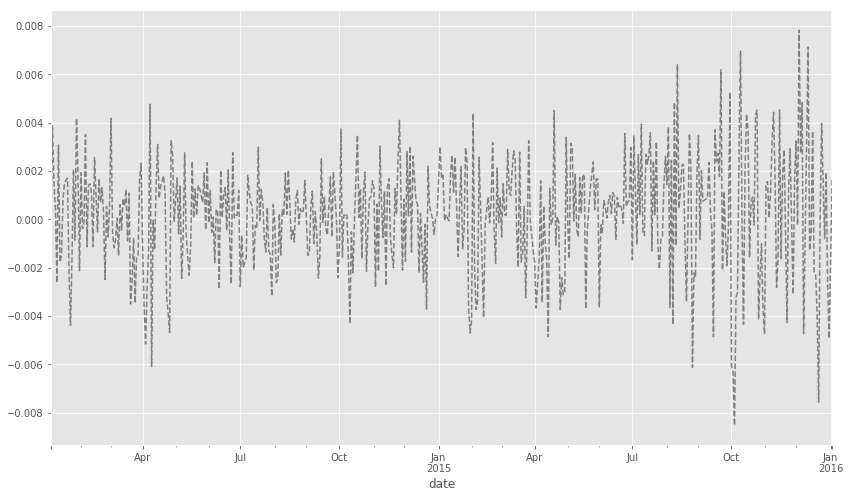

In [46]:
#unsmoothed_factor_return['Momentum_Factor'].plot(color='orange')
smoothed_factor_return['Smoothed_Momentum_Factor'].plot(color='gray',style='--');

## Open ended question
How would you describe the smoothed and unsmoothed factor returns?

## Answer here
The factor returns are fairly similar in this example.

## Solution notebook
[The solution notebook is here.](factor_returns_solution.ipynb)